In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import random
from collections import deque
from typing import Union, Tuple
import warnings 
import copy
import time 
import matplotlib.pyplot as plt
import pandas as pd

# Iperparametri
GAMMA = 0.99
LR = 0.00005 # best 0.0001
LR_STEP_SIZE = 20000
LR_LINEAR_DECAY = 0.9
HIDDEN_LAYER_DIM = 64 # best 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.002 # best 0.002

TARGET_SOFT_UPDATE = True
TAU = 0.001
TARGET_UPDATE = 10 # best 10
TARGET_UPDATE_STEPS = 1000 # best 500
MEMORY_SIZE = 100000  
BATCH_SIZE = 128 # best 64
EPISODES = 3000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu') 

In [2]:
""" Definizione rete neurale """
class DQN(nn.Module):
    # Init rete neurale con 3 livelli nn.Linear 
    def __init__(self, state_dim: int, action_dim: int, device: torch.device,  hidden_dim: int = 64) -> None:
        super(DQN, self).__init__()
        self.device = device
        layers = [
            nn.Linear(state_dim, hidden_dim),       # Layer 1 lineare
            nn.ReLU(),                              # Layer 2 Relu per introdurre non linearità
            nn.Linear(hidden_dim, hidden_dim),      # Layer 3 lineare
            nn.ReLU(),                              # Layer 4 Relu per introdurre non linearità
            nn.Linear(hidden_dim, action_dim)       # Layer 5 lineare
        ]
        self.model = nn.Sequential(*layers).to(self.device)
        
    # Questa funzione viene esegutia autamaticamente quando eseguo net(state) con net instanza di DQN
    # Update rete a partire da un nuovo stato x. L'output è il valore aggiornato di Q(s,:)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # Calcolo q_values attraverso il modello
        q_values = self.model(x)
        return q_values

""" Definizione del replay buffer """
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        # Init del buffer per memorizzare le esperienze deque generare una coda a dimensione fissa.
        # Quando la dimensione supera la capcità si comporta in modo FIFO e scarto gli elementi
        #  più vecchi dal buffer
        self.buffer = deque(maxlen=capacity)

    def push(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, terminated: bool) -> None:
        # Funzione che aggiunge una nuova eseprienza < S, A, R, S', terminated > nel buffer
        self.buffer.append((state, action, reward, next_state, terminated))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        # Campiono tanti mini batch quanto definito in batch_size dal buffer contenente le 
        # esperienze in modo random e li decomprimo in tuple
        states, actions, rewards, next_states, terminateds = zip(*random.sample(self.buffer, batch_size))
        
        # Converto ogni elemento in array NumPy per facilitarne l'uso in PyTorch
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(terminateds)

    def __len__(self) -> int:
        # Restituisce il numero di eseprienze attualmente memorizzate nel buffer
        return len(self.buffer)

""" Funzione che seleziona un azione con una strategia del tipo eps-greedy """

def select_action(state: np.ndarray, policy_net: torch.nn.Module, epsilon: float, n_actions: int) -> int:
    # Converto lo stato in torch.Tensor e lo sposto sul device corretto
    state = torch.tensor(state, dtype=torch.float32, device = policy_net.device).unsqueeze(0)

    # Azione casuale con probabilità epsilon
    if random.random() < epsilon:
        return random.randint(0, n_actions -1)
        
    # Azione greedy con probabilità (1 - epsilon)
    with torch.no_grad():           # Disabilito il calcolo dei gradienti che non serve in questa fase
        # Seleziono l'azione col valore massimo di Q (non serve squeeze(0) perchè sto usando item())
        return policy_net(state).argmax(dim=1).item()

"""  Aggiorna i parametri della rete tramite la perdita MSE tra Q-valori predetti e target. """
def optimize_model(policy_net: DQN, target_net: DQN, memory: ReplayBuffer, optimizer: torch.optim.Optimizer) -> torch.Tensor:
    # Genera un warning se non ci sono abbastanza esperienze nel replay buffer e non aggiorna la rete
    if len(memory) < BATCH_SIZE:
        warnings.warn(f"Il replay buffer contiene solo {len(memory)} esperienze, meno del batch size richiesto ({BATCH_SIZE}).", 
                      category=UserWarning)
        return

    # Campiono una serie di batch dal buffer
    states, actions, rewards, next_states, terminateds = memory.sample(BATCH_SIZE)

    # Converto tutto in tensori e sposta sul device della rete policy_net
    device = policy_net.device
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    terminateds = torch.tensor(terminateds, dtype=torch.float32).to(device)

    # Calcola i Q-valori predetti dalla rete principale per le azioni eseguite
    # policy_net(states) -> tensore (batch_size, n_actions) con i Q values delle azioni per ogni stato nel batch
    # gather(1, actions) -> seleziona i Q-valori associati alle azioni effettivamente eseguite (actions)
    #                       actions è un tensore di indici delle azioni con dimensione (batch_size, 1)
    # squeeze(1) -> rimuove la dimensione extra (batch_size, 1) -> (batch_size,)
    q_values = policy_net(states).gather(1, actions).squeeze(1)

    # Calcolo i q_values massimi previsti dalla rete target per gli stati successivi
    # target_net(next_states) -> fornisce un tensore (batch_size, n_actions)
    # max(1) -> estrae i valori massimi lungo la dim 1, ovvero quelli delle azioni e ottengo una tupla
    # con (valori massimi di Q per ogni batch, azione associata per ogni batch)
    # Di questa tupla estraiamo solo i valori massimi di Q, non ci interessa l'azione
    next_q_values = target_net(next_states).max(1)[0]
    
    # A questo punto calcolo i target per ognuno dei next_q_values ottenuti
    target_q_values = rewards + GAMMA * next_q_values * (1 - terminateds)

    # Calcolo la perdita tra i valori predetti dalla rete principale e quelli della rete
    # target usando l'errore quadratico medio MSE
    loss = nn.MSELoss()(q_values, target_q_values.detach())
    # loss = nn.SmoothL1Loss()(q_values, target_q_values.detach())

    # Esegue il backpropagation e aggiorna i parametri della rete
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

# Funzione per il decadimento di epsilon
def eps_decay(episode, decay_type='linear') -> float:
    
    if decay_type == 'linear':
        return np.max([EPSILON_MIN, EPSILON_MAX * (1 - episode / (EPISODES))])
        
    elif decay_type == 'exp':
        return np.max([EPSILON_MIN, EPSILON_MAX * np.exp(-EPSILON_DECAY * episode)])
    else:
        return 0 

def soft_update(policy_net, target_net):
    for target_param, param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)

In [3]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Genero reti neurali
policy_net = DQN(state_dim, action_dim, device, hidden_dim=HIDDEN_LAYER_DIM)
target_net = DQN(state_dim, action_dim, device, hidden_dim=HIDDEN_LAYER_DIM)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Inizializza il ReplayBuffer e l'ottimizzatore
replay_buffer = ReplayBuffer(MEMORY_SIZE)
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_LINEAR_DECAY)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

# Raccolta dati
total_reward = np.zeros(EPISODES)
eps_history = np.zeros(EPISODES)
lr_history = np.zeros(EPISODES)
loss_history = []
lr_history_step = []
learning_steps = 0

# Init cronometro
start_time = time.time()

for episode in range(EPISODES):
    # Reset env
    state, info = env.reset()
    done = False
    epsilon = eps_decay(episode, 'linear')
    eps_history[episode] = epsilon

    lr_history[episode] = optimizer.param_groups[0]['lr']
    # Scheduler step per ridurre il learning rate
    # if learning_steps > 0:
    #     scheduler.step()
        
    while not done:
        # Seleziono l'azione dalla policy_net
        action = select_action(state, policy_net, epsilon, action_dim)

        # Eseguo l'azione sull'ambiente
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Salvo il batch nel buffer
        replay_buffer.push(state, action, reward, next_state, terminated)

        # Quando ho abbasatanza dati ottimizzo la rete policy_net
        if len(replay_buffer) > BATCH_SIZE:
            loss = optimize_model(policy_net, target_net, replay_buffer, optimizer)
            if episode > EPISODES/2:
                scheduler.step()
            # Soft update della rete target
            if TARGET_SOFT_UPDATE:
                soft_update(policy_net, target_net)
            loss_history.append(loss.cpu().detach().numpy())
            learning_steps += 1
            
        # Passo al prossimo step
        total_reward[episode] += reward
        state = next_state
        lr_history_step.append(optimizer.param_groups[0]['lr'])
        
        # Update rete target ogni TARGET_UPDATE_STEP
        if learning_steps % TARGET_UPDATE_STEPS == 0 and learning_steps != 0 and not TARGET_SOFT_UPDATE:
            target_net.load_state_dict(policy_net.state_dict())

    # Update adattivo lR
    # if episode % 10 == 0 and episode >= 1000:  
    #     ma_reward = np.mean(total_reward[episode-100:episode])  # Calcola la media mobile della reward
    #     scheduler.step(ma_reward)  # Usa ma_reward per ridurre il learning rate se necessario

    # Stampa il totale del reward per questo episodio
    if episode % 100 == 0 and episode != 0:
        ma_reward = np.mean(total_reward[episode-100:episode])
        ma_loss = np.mean(loss_history[-100:])
        lr = optimizer.param_groups[0]['lr']
        print(f"Ep {episode}/{EPISODES}, MA Reward: {ma_reward:.2f}, MA loss: {ma_loss:.4f}, LR: {lr:.2e}, Eps: {epsilon:.2f}")

total_time = time.time() - start_time

# Chiudi l'ambiente
env.close()
print(f"Training finito in: {total_time:.2f} secondi")

# Salvo i dati in un file CSV alla fine dell'addestramento
data = {
    'episode': np.arange(len(total_reward)),
    'reward': total_reward,
    'epsilon': eps_history,
    'lr_per_ep' : lr_history
}

# Creo un DataFrame per i dati
df = pd.DataFrame(data)

# Salvo il file CSV con i dati di reward ed epsilon
df.to_csv('training_data_ep.csv', index=False)

# Salvo anche la lista della loss ad ogni step in un altro file CSV
df_loss = pd.DataFrame({'step_loss': loss_history})
df_lr_step = pd.DataFrame({'lr_per_step' : lr_history_step})

df_loss.to_csv('loss_per_step.csv', index=False)
df_lr_step.to_csv('lr_per_step.csv', index=False)

print("Dati salvati")

Ep 100/3000, MA Reward: 20.43, MA loss: 0.0570, LR: 5.00e-05, Eps: 0.97
Ep 200/3000, MA Reward: 19.47, MA loss: 0.2343, LR: 5.00e-05, Eps: 0.93
Ep 300/3000, MA Reward: 25.22, MA loss: 0.4268, LR: 5.00e-05, Eps: 0.90
Ep 400/3000, MA Reward: 26.95, MA loss: 0.6498, LR: 5.00e-05, Eps: 0.87
Ep 500/3000, MA Reward: 34.72, MA loss: 0.9112, LR: 5.00e-05, Eps: 0.83
Ep 600/3000, MA Reward: 37.38, MA loss: 1.1640, LR: 5.00e-05, Eps: 0.80
Ep 700/3000, MA Reward: 40.10, MA loss: 1.6016, LR: 5.00e-05, Eps: 0.77
Ep 800/3000, MA Reward: 38.68, MA loss: 2.1456, LR: 5.00e-05, Eps: 0.73
Ep 900/3000, MA Reward: 49.89, MA loss: 3.1685, LR: 5.00e-05, Eps: 0.70
Ep 1000/3000, MA Reward: 56.11, MA loss: 4.3689, LR: 5.00e-05, Eps: 0.67
Ep 1100/3000, MA Reward: 59.28, MA loss: 6.2359, LR: 5.00e-05, Eps: 0.63
Ep 1200/3000, MA Reward: 69.52, MA loss: 7.9966, LR: 5.00e-05, Eps: 0.60
Ep 1300/3000, MA Reward: 79.79, MA loss: 11.7919, LR: 5.00e-05, Eps: 0.57
Ep 1400/3000, MA Reward: 103.98, MA loss: 11.6206, LR: 5.00

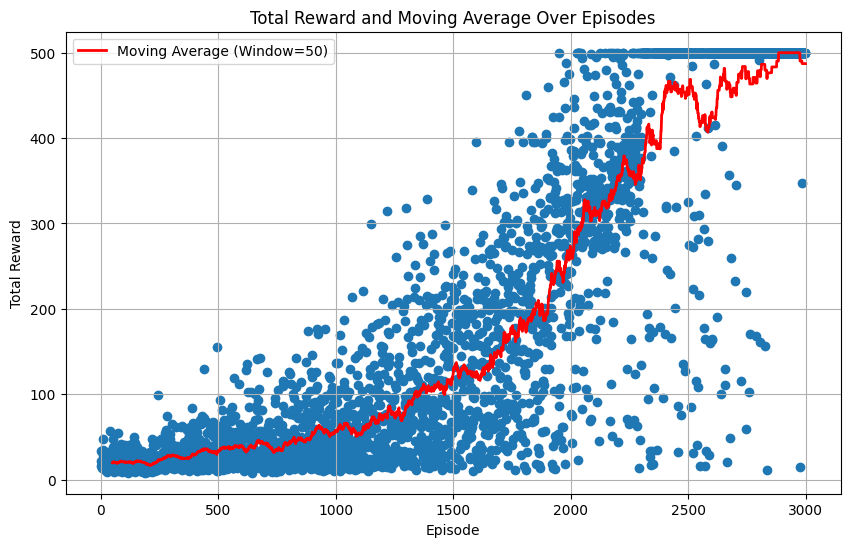

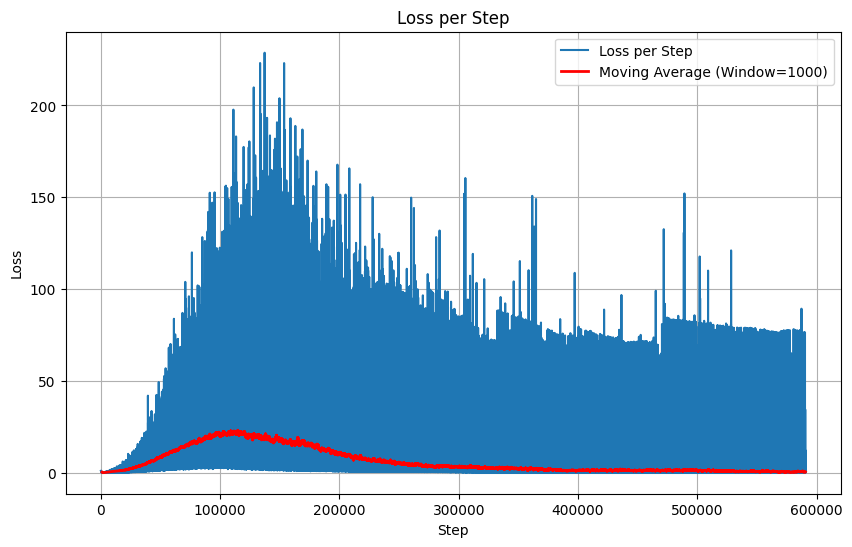

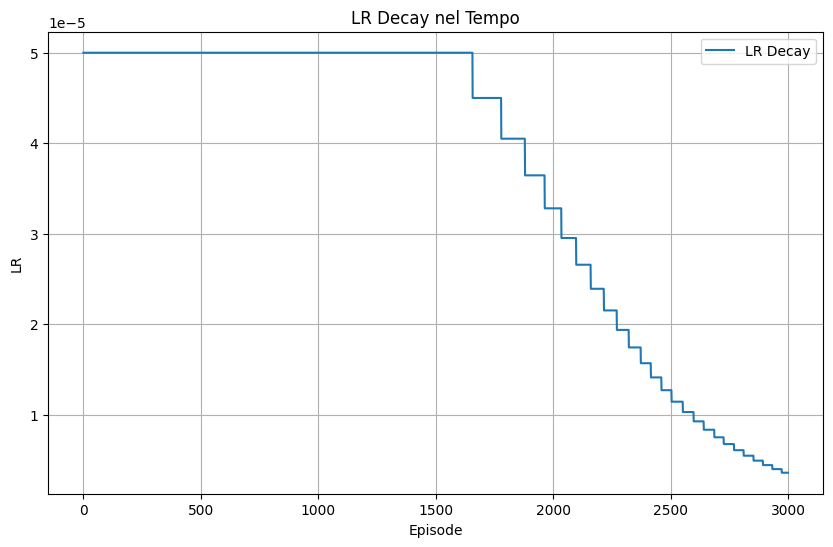

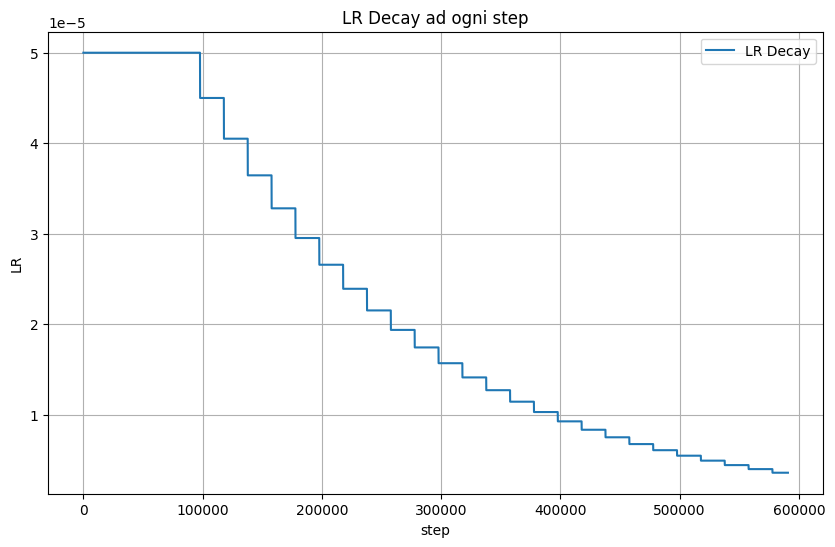

In [4]:
window_size = 50
ma_reward = np.convolve(total_reward, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_reward)), total_reward)
plt.plot(np.arange(window_size - 1, EPISODES), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)

plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


# Plot della loss per step
window_size = 1000
STEPS = len(loss_history)
ma_loss = np.convolve(loss_history, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_history)), loss_history, label='Loss per Step')
plt.plot(np.arange(window_size - 1, STEPS), ma_loss, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot del decadimento del LR per episodio
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(lr_history)), lr_history, label='LR Decay')
plt.title('LR Decay nel Tempo')
plt.xlabel('Episode')
plt.ylabel('LR')
plt.grid(True)
plt.legend()
plt.show()

# Plot del decadimento del LR per step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(lr_history_step)), lr_history_step, label='LR Decay')
plt.title('LR Decay ad ogni step')
plt.xlabel('step')
plt.ylabel('LR')
plt.grid(True)
plt.legend()
plt.show()

# Plot del decadimento di epsilon
# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(len(eps_history)), eps_history, label='Epsilon Decay')
# plt.title('Epsilon Decay nel Tempo')
# plt.xlabel('Episode')
# plt.ylabel('Epsilon')
# plt.grid(True)
# plt.legend()
# plt.show()

In [ ]:
env = gym.make('CartPole-v1', render_mode = 'human')

for ep in range(10):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = select_action(state, policy_net, 0, action_dim)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward

    print('total reward: ' + str(total_reward))
env.close()

In [ ]:
optimizer.param_groups[0]['lr']